# Feedback-Loop Price Forecast
#### Senapati Sang Diwangkara | February 2019

# Constants

In [1]:
# Pseudorandom Seed
SEED = 69
from numpy.random import seed
seed(SEED)
from tensorflow import set_random_seed
set_random_seed(SEED)
print("Random seed: {}".format(SEED))

# Source definition
FILENAME = "data/QUANDL.csv"
VALIDATION_SPLIT = 0.03
TEST_SPLIT = 0.01
#     train_split | vali_split | test_split
#     e.g. If the vali split is 0.1, the test split is 0.2, and the data length is 1000,
#         then first 700 data will be used for training, 100 after that (700 - 799) for validation
#         and 200 after that (800 - 999) for testing.
FUTURE_BATCH = 7 # How many timestep to look ahead

# Data properties
TIMESTEP_SIZE = 30 # Some people call this "Window size"
USECOLS = [1] # Which column to use
PRICE_COL = 0 # From said USECOLS, which index is the price?

# Training Properties
EPOCHS = 200
BATCH_SIZE = 10
DROPOUT_VALUE = 0.2
STATEFUL = False
#     From Keras recurent layer docs:
#     stateful: Boolean (default False). If True, the last state for each sample at index i in a batch 
#     will be used as initial state for the sample of index i in the following batch.

Random seed: 69


# Model Definition

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import LeakyReLU, Flatten

model = Sequential()
# Input layer
model.add(LSTM(len(USECOLS), 
    batch_input_shape=(BATCH_SIZE, TIMESTEP_SIZE, len(USECOLS)),
    return_sequences=True,
    stateful=STATEFUL))
model.add(LeakyReLU())
# Hidden layer (i-have-no-idea-what-im-doing.png)
model.add(Dropout(DROPOUT_VALUE, seed=SEED))
model.add(LSTM(256, return_sequences=True, stateful=STATEFUL))
model.add(LeakyReLU())
model.add(Dropout(DROPOUT_VALUE, seed=SEED))
model.add(LSTM(128, stateful=STATEFUL))
model.add(LeakyReLU())
model.add(Dropout(DROPOUT_VALUE, seed=SEED))
model.add(Dense(64))
model.add(LeakyReLU())
# Output layer
model.add(Dense(len(USECOLS), activation='linear'))

model.compile(loss='mse', optimizer='adam')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (10, 30, 1)               12        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (10, 30, 1)               0         
_________________________________________________________________
dropout_1 (Dropout)          (10, 30, 1)               0         
_________________________________________________________________
lstm_2 (LSTM)                (10, 30, 256)             264192    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (10, 30, 256)             0         
_________________________________________________________________
dropout_2 (Dropout)          (10, 30, 256)             0         
_________________________________________________________________
lstm_3 (LSTM)                (10, 128)                 197120    
__________

# Utility Function

In [3]:
import numpy as np
import pandas as pd

# Uses generator, for data scalability
def read_raw_datum(filename, usecols): 
    for datum in pd.read_csv(filename, chunksize=1, usecols=usecols):
        yield np.array(datum.values[0])
    
def get_max(filename, usecols):
    result = np.array([])
    for row in read_raw_datum(filename, usecols):
        if len(result) == 0: 
            result = row
        else:
            for col in range(row.shape[0]):
                if result[col] < row[col]:
                    result[col] = row[col]
    return result
    
def get_min(filename, usecols):
    result = np.array([])
    for row in read_raw_datum(filename, usecols):
        if result.size == 0: 
            result = row
        else:
            for col in range(row.shape[0]):
                if result[col] > row[col]:
                    result[col] = row[col]
    return result

def normalize(data, maxi, mini):
    return ((data - mini) / (maxi - mini))

def denormalize(data, maxi, mini):
    return (data * (maxi - mini) + mini)

# Converts (row, column) data to (batch_size, timestep_size, column)
def batchify(data, timestep_size, batch_size):
    x_batch_buffer = []
    y_batch_buffer = []
    x_timestep_buffer = []
    # Collecting timesteps for a batch
    for timestep_idx in range(batch_size):
        x_timestep_buffer = x_timestep_buffer.copy()
        stop = min(timestep_idx + timestep_size, len(data) - 1)
        if not x_timestep_buffer:
            start = timestep_idx
        else:
            start = stop - 1
            del x_timestep_buffer[0]
        # Collecting data for a timestep    
        for datum_idx in range(start, stop + 1):
            x_timestep_buffer.append(data[datum_idx])
        y_timestep_buffer = x_timestep_buffer.pop()
        x_batch_buffer.append(x_timestep_buffer)
        y_batch_buffer.append(y_timestep_buffer)
        if stop == len(data): break
    return np.array(x_batch_buffer), np.array(y_batch_buffer)

def batchify_x_only(data, timestep_size, batch_size):
    x_batch_buffer = []
    x_timestep_buffer = []
    # Collecting timesteps for a batch
    for timestep_idx in range(batch_size):
        x_timestep_buffer = x_timestep_buffer.copy()
        stop = min(timestep_idx + timestep_size, len(data))
        if not x_timestep_buffer:
            start = timestep_idx
        else:
            start = stop - 1
            del x_timestep_buffer[0]
        # Collecting data for a timestep    
        for datum_idx in range(start, stop):
            x_timestep_buffer.append(data[datum_idx])
        x_batch_buffer.append(x_timestep_buffer)
        if stop == len(data): break
    return np.array(x_batch_buffer)

# Training

In [4]:
# Getting data statistics
len_data = sum(1 for _ in read_raw_datum(FILENAME, USECOLS))
max_data = get_max(FILENAME, USECOLS)
min_data = get_min(FILENAME, USECOLS)

In [5]:
for epoch in range(EPOCHS):
    tr_loss = []
    va_loss = []
    chunk_idx = 1
    # Read data in chunks so it will be more scalable
    for chunk in pd.read_csv(FILENAME, chunksize=BATCH_SIZE + TIMESTEP_SIZE, usecols=USECOLS):
        chunk_norm = normalize(chunk.values, max_data, min_data)
        X, y = batchify(chunk_norm, TIMESTEP_SIZE, BATCH_SIZE)
        if not ((chunk_idx * (BATCH_SIZE + TIMESTEP_SIZE)) > ((1 - VALIDATION_SPLIT - TEST_SPLIT) * len_data)):
            # Training
            loss = model.train_on_batch(X, y)
            tr_loss.append(loss)
        elif not ((chunk_idx * (BATCH_SIZE + TIMESTEP_SIZE)) > ((1 - TEST_SPLIT) * len_data)):
            # Validation
            loss = model.test_on_batch(X, y)
            va_loss.append(loss)
        else: break # Testing data is not processed
        chunk_idx = chunk_idx + 1
    if STATEFUL and not epoch == EPOCHS - 1: model.reset_states()
    print("Epoch {}: \t tr_loss = {} \t va_loss = {}".format(epoch, sum(tr_loss) / float(len(tr_loss)), sum(va_loss) / float(len(va_loss))))

model.save("saved_model/test.h5")

Epoch 0: 	 tr_loss = 0.01310479400442991 	 va_loss = 0.05495348572731018
Epoch 1: 	 tr_loss = 0.026763533574653917 	 va_loss = 0.01235841994639486
Epoch 2: 	 tr_loss = 0.026979576078149745 	 va_loss = 0.08779991790652275
Epoch 3: 	 tr_loss = 0.024219674020943265 	 va_loss = 0.08636537939310074
Epoch 4: 	 tr_loss = 0.020018617727328093 	 va_loss = 0.013386006467044353
Epoch 5: 	 tr_loss = 0.006975461154589928 	 va_loss = 0.013413882115855813
Epoch 6: 	 tr_loss = 0.015485046620207348 	 va_loss = 0.007889894885011017
Epoch 7: 	 tr_loss = 0.007311324486051619 	 va_loss = 0.05270780995488167
Epoch 8: 	 tr_loss = 0.0035765035774342584 	 va_loss = 0.019453015178442
Epoch 9: 	 tr_loss = 0.0059321543162306105 	 va_loss = 0.047499144449830055
Epoch 10: 	 tr_loss = 0.011182922854953046 	 va_loss = 0.008572312304750085
Epoch 11: 	 tr_loss = 0.0029529756838331065 	 va_loss = 0.011828739661723375
Epoch 12: 	 tr_loss = 0.005090592738893715 	 va_loss = 0.020135353319346905
Epoch 13: 	 tr_loss = 0.0052

Epoch 108: 	 tr_loss = 0.003346484082119007 	 va_loss = 0.007356333080679178
Epoch 109: 	 tr_loss = 0.00420787055445544 	 va_loss = 0.009185235481709242
Epoch 110: 	 tr_loss = 0.0033098247011886478 	 va_loss = 0.007624851306900382
Epoch 111: 	 tr_loss = 0.0042225647968734846 	 va_loss = 0.009341944009065628
Epoch 112: 	 tr_loss = 0.0030072423934013517 	 va_loss = 0.003826868603937328
Epoch 113: 	 tr_loss = 0.004597194742694098 	 va_loss = 0.005291449371725321
Epoch 114: 	 tr_loss = 0.00323063881478447 	 va_loss = 0.009968236088752747
Epoch 115: 	 tr_loss = 0.0034494863467573723 	 va_loss = 0.005651776911690831
Epoch 116: 	 tr_loss = 0.0030863803840475157 	 va_loss = 0.015887961722910404
Epoch 117: 	 tr_loss = 0.003448049456294809 	 va_loss = 0.004307897994294763
Epoch 118: 	 tr_loss = 0.002639982923990049 	 va_loss = 0.016286837868392467
Epoch 119: 	 tr_loss = 0.002458695134555455 	 va_loss = 0.003676852094940841
Epoch 120: 	 tr_loss = 0.002372320060697218 	 va_loss = 0.012748359702527

# Testing and Prediction

In [6]:
y_actual = []
y_predict = []
chunk_idx = 1
do_fill = True
# Grabbing the testing data
for chunk in pd.read_csv(FILENAME, chunksize=BATCH_SIZE + TIMESTEP_SIZE, usecols=USECOLS):
    if ((chunk_idx * (BATCH_SIZE + TIMESTEP_SIZE)) > ((1 - TEST_SPLIT) * len_data)):
        chunk_norm = normalize(chunk.values, max_data, min_data)
        if do_fill: 
            # Only fill the initial chunk for our prediction, because we will generate the remaining data later
            y_predict.extend(chunk_norm)
            do_fill = False
        y_actual.extend(chunk_norm)
    chunk_idx = chunk_idx + 1
# Feedback-loop, generate y_predict from itself
for idx in range(1, int((1 - VALIDATION_SPLIT - TEST_SPLIT) * len_data) % (BATCH_SIZE + TIMESTEP_SIZE) - 1 + FUTURE_BATCH):
    #print(np.array(y_predict[idx: (idx + BATCH_SIZE + TIMESTEP_SIZE - 1)]))
    X = batchify_x_only(y_predict[idx: (idx + BATCH_SIZE + TIMESTEP_SIZE - 1)], TIMESTEP_SIZE, BATCH_SIZE)
    y_predict.append(model.predict_on_batch(X)[-1, :])
    
y_actual = np.array(y_actual)
y_predict = np.array(y_predict)

In [7]:
# Needs to import matplotlib in a different cell
# https://github.com/jupyter/notebook/issues/3691
import matplotlib.pyplot as plt

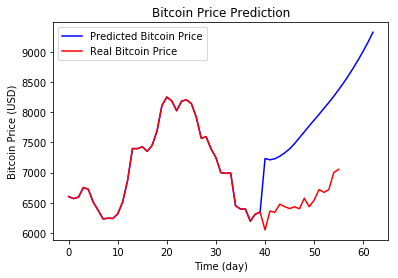

In [8]:
# Visualising the results
price_actual = denormalize(y_actual, max_data, min_data)[:, PRICE_COL]
price_predict = denormalize(y_predict, max_data, min_data)[:, PRICE_COL]
plt.plot(price_predict, color = 'blue', label = 'Predicted Bitcoin Price')
plt.plot(price_actual, color = 'red', label = 'Real Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time (day)')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.show()